In [32]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd "//content/drive/My Drive/Colab Notebooks/ComputationalNeuroscience/FinalProject"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks/ComputationalNeuroscience/FinalProject


In [0]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from keras.utils.np_utils import to_categorical
from keras.datasets import cifar10
from keras.datasets import mnist

### Loading dataset

In [0]:
def preprocess(dataset, normalize=True):

    if dataset == 'mnist':
        (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
        X_train = np.reshape(X_train, (60000, 784))
        X_test = np.reshape(X_test, (10000, 784))
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

        Y_train = to_categorical(Y_train, num_classes=10)
        Y_test = to_categorical(Y_test, num_classes=10)

    elif dataset == 'cifar10':
        (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
        X_train = np.reshape(X_train, (50000, 3072))
        X_test = np.reshape(X_test, (10000, 3072))
        X_train = X_train.astype('float32')
        X_test = X_test.astype('float32')

        Y_train = to_categorical(Y_train, num_classes=10)
        Y_test = to_categorical(Y_test, num_classes=10)

    # Normalization of pixel values to [0-1] range

    if normalize:
        X_train /= 255
        X_test /= 255

    return (X_train, Y_train), (X_test, Y_test)

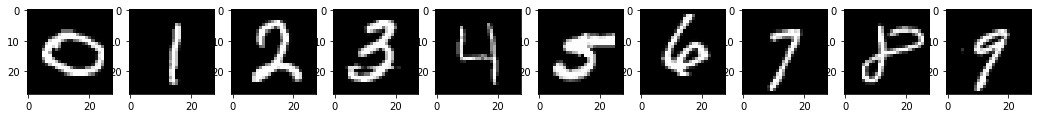

In [0]:
# Load the data
(X_train, Y_train), (X_test, Y_test) = preprocess('mnist')

# Show a couple of data 
plt.figure(figsize = (18,4))

for i in range(10):
  r = np.random.randint(len(X_train))
  while np.where(Y_train[r] == 1)[0][0] != i:
    r = np.random.randint(len(X_train))

  plt.subplot(1, 10, i+1)
  plt.imshow(X_train[r].reshape(28, 28), cmap = 'gray')

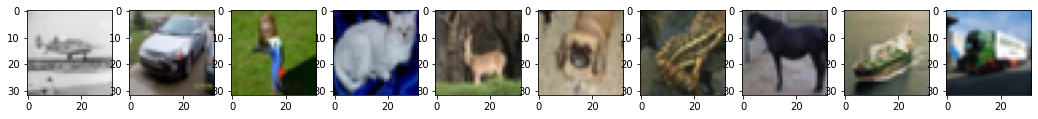

In [0]:
# Load the data
(X_train, Y_train), (X_test, Y_test) = preprocess('cifar10')

# Show a couple of data 
plt.figure(figsize = (18,4))

for i in range(10):
  r = np.random.randint(len(X_train))
  while np.where(Y_train[r] == 1)[0][0] != i:
    r = np.random.randint(len(X_train))

  plt.subplot(1, 10, i+1)
  plt.imshow(X_train[r].reshape(32, 32, 3))

### Conventional ML algorithms (PCA ...)

In [0]:
# 
#Please enter your code here
#

### Network class with backpropagation algorithm

In [0]:
#============================================================
# Untility functions
#============================================================
def OneHot(z):
    '''
       Example: OneHot([[0.9, 0.1], [-0.5, 0.1]])
          returns np.array([[1,0],[0,1]])
    '''
    y = []
    # Locate the max of each row
    for zz in z:
        idx = np.argmax(zz)
        b = np.zeros_like(zz)
        b[idx] = 1.
        y.append(b)
    y = np.array(y)
    return y

def Shuffle(inputs, targets):
    data = list(zip(inputs, targets))
    np.random.shuffle(data)
    s_inputs, s_targets = zip(*data)
    return np.array(s_inputs), np.array(s_targets)

def MakeBatches(data_in, data_out, batch_size = 10, shuffle = True):
    N = len(data_in)
    r = range(N)
    if shuffle:
        r = np.random.permutation(N)
    batches = []
    for k in range(0, N, batch_size):
        if k + batch_size <= N:
            din = data_in[r[k: k + batch_size]]
            dout = data_out[r[k: k + batch_size]]
        else:
            din = data_in[r[k:]]
            dout = data_out[r[k:]]
        if isinstance(din, (list, tuple)):
            batches.append( [np.stack(din, dim=0) , np.stack(dout, dim = 0)] )
        else:
            batches.append( [din, dout] )

    return batches

#==================================================
# Cost Functions
#==================================================
def CategoricalCE(y, t):
    return -np.sum(t * np.log(y)) / len(t)

#==================================================
# Layer Class
#==================================================
class Layer():
    def __init__(self, n_nodes=0, act = 'logistic'):
        self.N = n_nodes  # number of nodes in this layer
        self.h = []       # node activities
        self.z = []
        self.b = np.zeros(self.N)  # biases

        if act=='softmax':
            self.sigma = self.Softmax
            self.sigma_p = None
        elif act=='logistic':
            self.sigma = self.Logistic
            self.sigma_p = self.Logistic_p

    def Logistic(self):
        return 1. / (1. + np.exp(-self.z))
    def Logistic_p(self):
        return self.h * (1. - self.h)
    def Softmax(self):
        v = np.exp(self.z)
        s = np.sum(v, axis = 1)
        return v / np.tile(s[:, np.newaxis], [1, np.shape(v)[1]])

#==================================================
# Network Class
#==================================================
class Network():

    def __init__(self, sizes, type='classifier'):
        self.n_layers = 0 #len(sizes)
        self.lyr = []    # a list of Layers
        self.W = []      # Weight matrices, indexed by the layer below it

        self.type = type # 'Bernoulli', 'classifier', 'regression'
        self.Loss = CategoricalCE
        self.output_activation = 'softmax'

        # Create and add Layers (using logistic for hidden layers)
        for n in sizes[:-1]:
            self.AddLayer( Layer(n) )
        # For the top layer, we use the appropriate activtaion function
        self.AddLayer( Layer(sizes[-1], act = self.output_activation) )


    def AddLayer(self, layer):
        self.lyr.append(layer)
        self.n_layers += 1
        # If this isn't our first layer, add connection weights
        if self.n_layers >= 2:
            m = self.lyr[-1].N
            n = self.lyr[-2].N
            temp = np.random.normal(size = [n,m]) / np.sqrt(n)
            self.W.append(temp)

    def FeedForward(self, x):
        x = np.array(x)  # Convert input to array, in case it's not

        self.lyr[0].h = x # [1] Set input layer

        # Loop over connections...
        for pre,post,W in zip(self.lyr[:-1], self.lyr[1:], self.W):

            # Calc. (and record) input current to next layer
            post.z = pre.h @ W + post.b

            # Use activation function to get activities
            post.h = post.sigma()

        # Return activity of output layer
        return self.lyr[-1].h

    def TopGradient(self, t):
        return ( self.lyr[-1].h - t ) / len(t)

    def BackProp(self, t, lrate = 0.05, decay = 0.):
        t = np.array(t)  # convert t to an array, in case it's not

        # Error gradient for top layer
        dEdz = self.TopGradient(t)

        # Loop down through the layers; Start second-from-the-top, and go down to layer 0
        for i in range(self.n_layers - 2, -1, -1):
            pre = self.lyr[i]

            # Gradient w.r.t. weights
            dEdW = pre.h.T @ dEdz

            # Gradient w.r.t. biases
            dEdb = np.sum(dEdz, axis = 0)

            # Project error gradient down to layer below
            dEdz = ( dEdz @ self.W[i].T ) * pre.sigma_p()

            # Update weights and biases
            self.W[i] -= lrate * dEdW
            self.lyr[i + 1].b -= lrate * dEdb

            #Applying decay to avoid overfitting
            self.W[i] -= 2 * self.W[i] * decay * lrate             # L2 decay
            self.lyr[i + 1].b -= 2 * self.lyr[i + 1].b * decay * lrate # L2 decay

    def SGD(self, inputs, targets, testInputs, testTargets, lrate=0.05, decay = 0.,  epochs=1, batch_size=10):
        loss_history = []   
        testAcc_history = []

        for k in range(epochs):
            batches = MakeBatches(inputs, targets, batch_size = batch_size, shuffle = False)
            for mini_batch in batches:
                self.FeedForward(mini_batch[0])
                self.BackProp(mini_batch[1], lrate = lrate, decay = decay)

            loss_history.append([k, self.Evaluate(inputs, targets)])
            testAcc_history.append([k, self.ClassificationAccuracy(testInputs, testTargets) * 100])

            print('Epoch ' + str(k) + ' cost: ' + str(loss_history[-1][1]) + ' test_accuracy: ' + str(testAcc_history[-1][1]) + ' %')

        return np.array(loss_history), np.array(testAcc_history)

    def Evaluate(self, inputs, targets):
        y = self.FeedForward(inputs)
        return self.Loss(y, targets)

    def ClassificationAccuracy(self, inputs, targets):
        y = self.FeedForward(inputs)
        yb = OneHot(y)
        n_incorrect = np.sum(yb != targets) / 2.
        return 1. - float(n_incorrect) / len(inputs)

#### Implemeting Backprop on MNIST

In [0]:
(X_train, Y_train), (X_test, Y_test) = preprocess('mnist')

In [0]:
net = Network([784, 500, 10], type = 'classifier') 

In [38]:
trainLoss, testAccuracy = net.SGD(X_train, Y_train, X_test, Y_test, lrate = 0.5, decay = 0.0, epochs = 400, batch_size = 128)

Epoch 0 cost: 0.3619611331335967 test_accuracy: 89.29 %
Epoch 1 cost: 0.29622260255420263 test_accuracy: 91.31 %
Epoch 2 cost: 0.25495168586381445 test_accuracy: 92.43 %
Epoch 3 cost: 0.22119596007795764 test_accuracy: 93.42 %
Epoch 4 cost: 0.1937982119310739 test_accuracy: 94.17999999999999 %
Epoch 5 cost: 0.17177732513410393 test_accuracy: 94.71000000000001 %
Epoch 6 cost: 0.15392264833676894 test_accuracy: 95.15 %
Epoch 7 cost: 0.13922561875260056 test_accuracy: 95.5 %
Epoch 8 cost: 0.12694110131313022 test_accuracy: 95.77 %
Epoch 9 cost: 0.11652732804205966 test_accuracy: 96.05 %
Epoch 10 cost: 0.10758345583946302 test_accuracy: 96.36 %
Epoch 11 cost: 0.09980937600231976 test_accuracy: 96.58 %
Epoch 12 cost: 0.09298011179313165 test_accuracy: 96.75 %
Epoch 13 cost: 0.08692635801391833 test_accuracy: 96.84 %
Epoch 14 cost: 0.08151997109005057 test_accuracy: 96.89999999999999 %
Epoch 15 cost: 0.07666238425556282 test_accuracy: 96.96000000000001 %
Epoch 16 cost: 0.07227472731188343 te

In [0]:
with open('BP_MNIST.pickle', 'wb') as f:
    pickle.dump(trainLoss, f)
    pickle.dump(testAccuracy, f)

Plot results

Text(0, 0.5, 'test accuracy %')

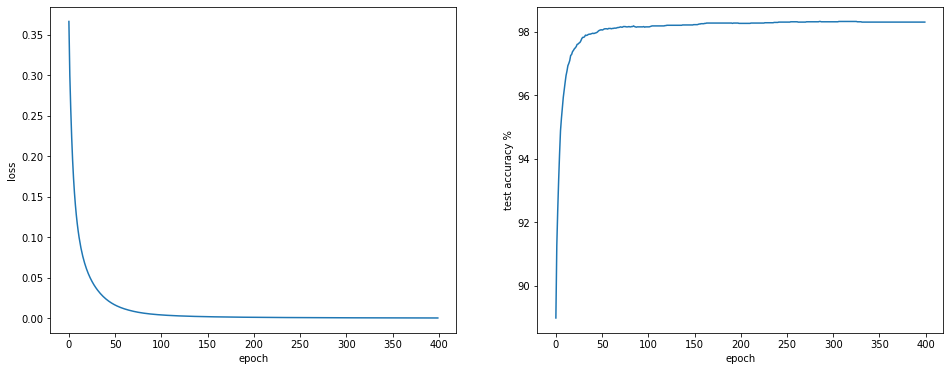

In [29]:
with open('BP_MNIST.pickle', 'rb') as f:
    trainLoss = pickle.load(f)
    testAccuracy = pickle.load(f)

plt.figure(figsize = (16, 6))
plt.subplot(1,2,1)
plt.plot(trainLoss[:, 0], trainLoss[:, 1])
plt.xlabel('epoch'); plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(testAccuracy[:, 0], testAccuracy[:, 1])
plt.xlabel('epoch'); plt.ylabel('test accuracy %')

#### Implemeting Backprop on CFAR10

In [31]:
(X_train, Y_train), (X_test, Y_test) = preprocess('cifar10')
net = Network([3072, 1000, 10], type = 'classifier') 
trainLoss, testAccuracy = net.SGD(X_train, Y_train, X_test, Y_test, lrate = 0.5, decay = 0.0, epochs = 400, batch_size = 128)

170500096/170498071 [==============================] - 6s 0us/step
Epoch 0 cost: 1.8949757368567903 test_accuracy: 33.269999999999996 %
Epoch 1 cost: 1.7820857855186059 test_accuracy: 36.870000000000005 %
Epoch 2 cost: 1.7219735062661317 test_accuracy: 38.6 %
Epoch 3 cost: 1.6600457543549885 test_accuracy: 40.400000000000006 %
Epoch 4 cost: 1.6062176630810783 test_accuracy: 42.06999999999999 %
Epoch 5 cost: 1.5753026747630938 test_accuracy: 42.910000000000004 %
Epoch 6 cost: 1.5452018718712894 test_accuracy: 44.13 %
Epoch 7 cost: 1.5231302980179442 test_accuracy: 44.620000000000005 %
Epoch 8 cost: 1.5507048440885212 test_accuracy: 43.21 %
Epoch 9 cost: 1.5147858170928945 test_accuracy: 44.19 %
Epoch 10 cost: 1.589821037166099 test_accuracy: 42.24 %
Epoch 11 cost: 1.5692274059131188 test_accuracy: 43.26 %
Epoch 12 cost: 1.4997083887963745 test_accuracy: 44.98 %
Epoch 13 cost: 1.4239527484652734 test_accuracy: 46.45 %
Epoch 14 cost: 1.4195193950334766 test_accuracy: 46.17 %
Epoch 15 cost

In [0]:
with open('BP_CFAR10.pickle', 'wb') as f:
    pickle.dump(trainLoss, f)
    pickle.dump(testAccuracy, f)

Text(0, 0.5, 'test accuracy %')

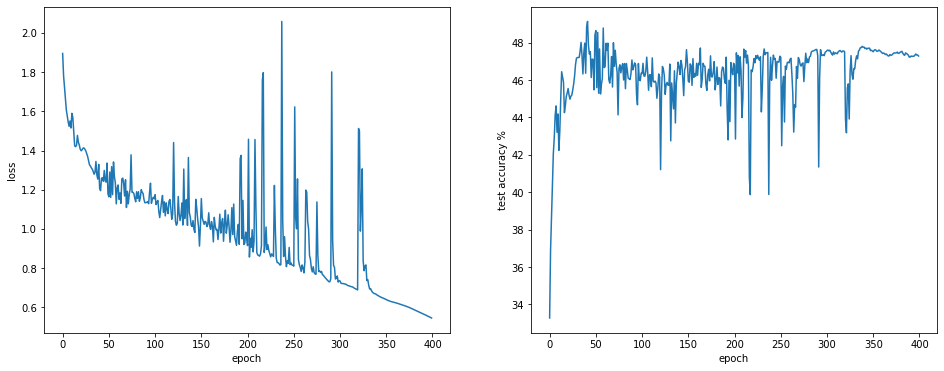

In [35]:
with open('BP_CFAR10.pickle', 'rb') as f:
    trainLoss = pickle.load(f)
    testAccuracy = pickle.load(f)

plt.figure(figsize = (16, 6))
plt.subplot(1,2,1)
plt.plot(trainLoss[:, 0], trainLoss[:, 1])
plt.xlabel('epoch'); plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(testAccuracy[:, 0], testAccuracy[:, 1])
plt.xlabel('epoch'); plt.ylabel('test accuracy %')

### Network class with feedback alighnment algorithm 